# Categorical Model Dedicated Notebook

## Data Admin:

15795
15795
15795
15795
(15795, 120, 160, 3)
4491


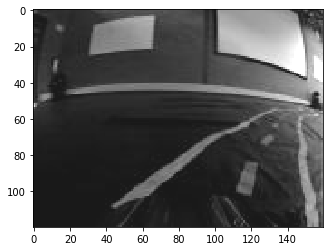

[0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [31]:
import os
import natsort
import numpy as np
import cv2
import json
import tensorflow as tf
from random import randrange

import matplotlib.pyplot as plt

%matplotlib inline

#finding and sorting images and label data: - Unthresholded Images!
path = 'halldatarecords2/'

im_list = []

rec_list = []

for file in os.listdir(path):
    if 'cam' in file:
        im_list.append(file)
    elif 'record' in file:
        rec_list.append(file)

        
print(len(im_list))
print(len(rec_list))

im_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
rec_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

#reading in array of images:
width = 160
height = 120
color = 3
#x_images = np.zeros((len(rec_list), 120, 160, 3), dtype = np.float32)
x_images = np.zeros((len(rec_list), height, width, color), dtype = np.float32)

randomImage = randrange(len(x_images))#14909
for i in range(len(im_list)):
    filename = im_list[i]
    image = cv2.imread(path+filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.convertScaleAbs(image, alpha=1.0, beta=25)
    #image = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,11,2)
    #image = cv2.resize(image,(height,width),interpolation = cv2.INTER_AREA)
    image = image.astype('uint8')
    image = image[..., None]
    x_images[i,:,:,:] = tf.cast(image, tf.float32)
    
#loop over labels and create a list of left/right/straight based on a degree threshold (one-hot encoding?)
json_data = {}
#y_labels = np.zeros((len(rec_list),3), dtype=np.float32) #setup label array for one-hot encoded left, right and straight
y_labels = np.zeros((len(rec_list),9), dtype=np.float32)
#[-35,-25,-15,-5,0,5,15,25,35]
for i in range(len(rec_list)):
    filename = rec_list[i]
    with open(path+filename) as fp:
        json_data = json.load(fp)
        orient = json_data['user/angle']
        orient = float(orient)
        if orient > (35.0/45.0):
            y_labels[i] = [0,0,0,0,0,0,0,0,1] #35+ right
        elif orient > (25.0/45.0):
            y_labels[i] = [0,0,0,0,0,0,0,1,0] #25+ right
        elif orient > (15.0/45.0):
            y_labels[i] = [0,0,0,0,0,0,1,0,0] #15+ right
        elif orient > (5.0/45.0):
            y_labels[i] = [0,0,0,0,0,1,0,0,0] #5+ right
        elif orient < -1*(35.0/45.0):
            y_labels[i] = [1,0,0,0,0,0,0,0,0] #35+ left
        elif orient < -1*(25.0/45.0):
            y_labels[i] = [0,1,0,0,0,0,0,0,0] #25+ left
        elif orient < -1*(15.0/45.0):
            y_labels[i] = [0,0,1,0,0,0,0,0,0] #15+ left
        elif orient < -1*(5.0/45.0):
            y_labels[i] = [0,0,0,1,0,0,0,0,0] #5+ left
        else:
            y_labels[i] = [0,0,0,0,1,0,0,0,0] #0
            
print(len(x_images))
print(len(y_labels))
print(x_images.shape)
print(randomImage)
plt.imshow(x_images[randomImage].astype('uint8'))
plt.show()
print(y_labels[randomImage])

(15795, 9)
700
1700
2700
3700
4700
5700
6700
7700
8700
9700
10700
11700
12700
13700
14700
(11057, 120, 160, 3)
(4739, 120, 160, 3)
(11057, 9)
(4739, 9)
[0. 0. 0. 0. 1. 0. 0. 0. 0.]


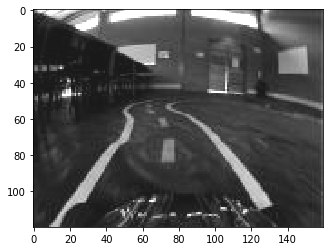

In [32]:
#training and validation split:

memv = 0
memt = 0
x_val = np.zeros((round(len(x_images)*0.3)+1,height, width, color), dtype=np.float32)
x_train = np.zeros((round(len(x_images)*0.7)+1,height, width, color), dtype=np.float32)
#y_val = np.zeros((round(len(x_images)*0.3)+1,3), dtype=np.float32)
#y_train = np.zeros((round(len(x_images)*0.7)+1,3), dtype=np.float32)
y_val = np.zeros((round(len(x_images)*0.3)+1,9), dtype=np.float32)
y_train = np.zeros((round(len(x_images)*0.7)+1,9), dtype=np.float32)

n=0
print(y_labels.shape)

for i in range(len(x_images)):
    if (i>=1000)and(i % 1000 == 0):
        j = i - 300
        k = i - 1000
        print(j)
        o = 0
        p = 0
        for l in range(0+n*300, n*300+300):
            #x_val[l] = x_images[j+o,:,:,:]
            x_val[l] = x_images[j+o,:,:,:]
            y_val[l] = y_labels[j+o]
            o +=1
        for m in range(0+n*700, n*700+700):
            #x_train[m] = x_images[k+p,:,:,:]
            x_train[m] = x_images[k+p,:,:,:]
            y_train[m] = y_labels[k+p]
            p+=1
        n+=1
        
print(x_train.shape)
print(x_val.shape)

print(y_train.shape)
print(y_val.shape)

print(y_val[1000])
plt.imshow(x_val[1000].astype('uint8'))
plt.show()
#obtaining test data

#relabeling test data

## Model Setup:

In [33]:
import os
import numpy as np

from tensorflow.python import keras
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Convolution2D, MaxPooling2D, Reshape, BatchNormalization
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Cropping2D, Lambda

#Model Structure Setup: no dropout, no regularization yet

#model = ''
model = Sequential()
#model.add(Convolution2D(24, (5,5), strides=(2,2), activation='relu', input_shape=(120, 160, 3)))
#Number of feature maps
#Kernel size matrix (thing that looks at picture)
#Strides is how kernel moves accross the image
#Activation is activation algorithm
#Input shape is the image
model.add(Convolution2D(16, (5,5), strides=(2,2), activation='relu', input_shape=(height, width, color)))
model.add(Convolution2D(32, (3,3), strides=(2,2), activation='relu'))
model.add(Convolution2D(64, (3,3), strides=(1,1), activation='relu'))
#model.add(Convolution2D(16, (3,3), strides=(1,1), activation='relu'))
model.add(Flatten())
#model.add(Dense(100, activation='relu'))#Arbitrary 
#model.add(Dense(50, activation='relu'))#Arbitrary
model.add(Dense(9, activation='softmax'))

model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 58, 78, 16)        1216      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 38, 32)        4640      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 26, 36, 64)        18496     
_________________________________________________________________
flatten_5 (Flatten)          (None, 59904)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 9)                 539145    
Total params: 563,497
Trainable params: 563,497
Non-trainable params: 0
_________________________________________________________________


## Training and Validation:

In [34]:
model.fit(x_train, y_train, epochs=20, batch_size=200, validation_data=(x_val, y_val), shuffle=True, verbose=1)

Train on 11057 samples, validate on 4739 samples
Epoch 1/20
11057/11057 [==============================] - 31s 3ms/sample - loss: 12.6597 - accuracy: 0.4444 - val_loss: 1.3922 - val_accuracy: 0.4564
Epoch 2/20
11057/11057 [==============================] - 30s 3ms/sample - loss: 0.6225 - accuracy: 0.7286 - val_loss: 1.7253 - val_accuracy: 0.4503
Epoch 3/20
11057/11057 [==============================] - 30s 3ms/sample - loss: 0.4568 - accuracy: 0.7908 - val_loss: 2.1449 - val_accuracy: 0.4779
Epoch 4/20
11057/11057 [==============================] - 30s 3ms/sample - loss: 1.1008 - accuracy: 0.6552 - val_loss: 1.5458 - val_accuracy: 0.4241
Epoch 5/20
11057/11057 [==============================] - 30s 3ms/sample - loss: 0.7198 - accuracy: 0.7041 - val_loss: 1.8848 - val_accuracy: 0.4235
Epoch 6/20
11057/11057 [==============================] - 30s 3ms/sample - loss: 0.5609 - accuracy: 0.7676 - val_loss: 2.0222 - val_accuracy: 0.4366
Epoch 7/20
11057/11057 [==============================] 

In [35]:
# Let's Evaluate
model.evaluate(x_val,  y_val, verbose=2)

4739/1 - 6s - loss: 1.8967 - accuracy: 0.4883


[3.7933694401158595, 0.48828867]

Expected
[0. 0. 0. 0. 0. 0. 0. 0. 1.]
Predicted
[0. 0. 0. 0. 0. 1. 0. 0. 0.]


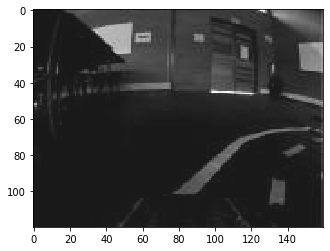

Expected
[0. 0. 0. 0. 0. 0. 0. 0. 1.]
Predicted
[0. 0. 0. 0. 0. 0. 0. 0. 1.]


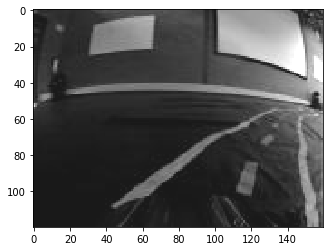

Expected
[0. 0. 0. 0. 1. 0. 0. 0. 0.]
Predicted
[0. 0. 0. 0. 0. 1. 0. 0. 0.]


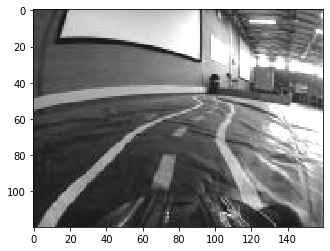

In [36]:
out = model.predict(x_images, batch_size=200)
out = np.around(out)
pointOne = randomImage
pointTwo = randomImage
pointThree = randomImage

if randomImage >= 100:
    pointOne = randomImage - 100
else:
    pointOne = 0
    
if randomImage <= len(x_images) + 100:
    pointThree = randomImage + 100
else:
    pointThree = len(x_images)

#if round(out[pointOne,0]) == 1:
#    print('left')
#elif round(out[pointOne, 1]) == 1:
#    print('straight')
#elif round(out[pointOne, 2]) == 1:
#    print('right')
print('Expected')
print(y_labels[pointOne])
print('Predicted')
print(out[pointOne])
plt.imshow(x_images[pointOne].astype('uint8'))
plt.show()

#if round(out[pointTwo,0]) == 1:
#    print('left')
#elif round(out[pointTwo, 1]) == 1:
#    print('straight')
#elif round(out[pointTwo, 2]) == 1:
#    print('right')
print('Expected')
print(y_labels[pointTwo])
print('Predicted')
print(out[pointTwo])
plt.imshow(x_images[pointTwo].astype('uint8'))
plt.show()

#if round(out[pointThree,0]) == 1:
#    print('left')
#elif round(out[pointThree, 1]) == 1:
#    print('straight')
#elif round(out[pointThree, 2]) == 1:
#    print('right')
print('Expected')
print(y_labels[pointThree])
print('Predicted')
print(out[pointThree])
plt.imshow(x_images[pointThree].astype('uint8'))
plt.show()